<a href="https://colab.research.google.com/github/OriRoth22/tierra_spec_task/blob/main/tierra_spec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#install dependencies

In [ ]:
!pip install pystac-client
!pip install odc-stac
!pip install rioxarray
!pip install netCDF4
!pip install rasterio
!pip install planetary-computer


In [27]:
!pip list | grep -E 'pystac-client|odc-stac|rioxarray|netCDF4|rasterio|planetary-computer'


netCDF4                            1.7.2
odc-stac                           0.3.11
planetary-computer                 1.0.0
pystac-client                      0.8.5
rasterio                           1.4.3
rioxarray                          0.18.1


I took the polygon true color image from google earth for convoneont reasons, to see where we are focusing

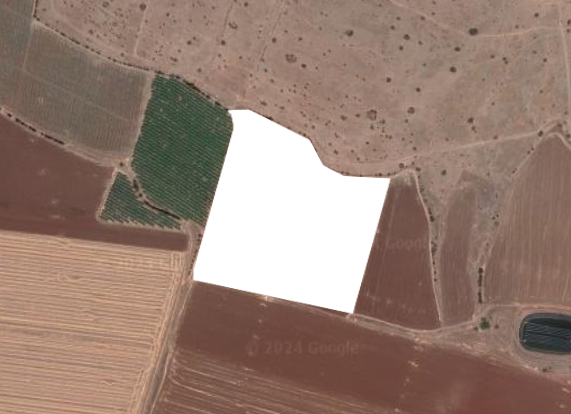

#import data
downlad scence that containe the polygon, with filtering of cloud cover less then 30% ( can be djusted)


filter time - 1 march 24  to 1th april 24



In [32]:

from shapely.geometry import box, Polygon
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
from shapely.geometry import shape
from shapely.geometry import box
import geopandas as gpd
import numpy as np
from pystac.extensions.eo import EOExtension as eo
import odc.stac

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

polygon_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [35.425319654, 32.566444657],
            [35.425263411, 32.566480554],
            [35.425629751, 32.566491813],
            [35.4267837, 32.566000681],
            [35.427050295, 32.565594612],
            [35.427458434, 32.565414986],
            [35.428331729, 32.565377635],
            [35.427650177, 32.563207762],
            [35.424608773, 32.563749924],
            [35.424609093, 32.563881124],
            [35.425375536, 32.566217865],
            [35.425319654, 32.566444657],
        ]
    ],
}
time_of_interest = "2024-03-11/2024-04-01"

search = catalog.search(
    collections=["landsat-c2-l2"], # search the landset 8/ 9 data
    intersects=polygon_geojson,
    datetime=time_of_interest,
    query={
        "eo:cloud_cover": {"lt": 15} # Maximum 15% cloud cover Adjust this threshold as needed

    },
)

items = search.item_collection() # get list of the item founded
print(f"Returned {len(items)} Items")
#print (items)




Returned 4 Items


# clipping the data anf filterind high NDVI scenes

now we want to remove scences with vegetation beacuse we want bare soil,

we are using the NDVI parameter (seee https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index)

we are using the NDHI parameter (seee https://www.researchgate.net/publication/348838043_A_high-resolution_index_suitable_for_multi-pollutant_monitoring_in_urban_areas)

im not sure if that was the intention of you, but couldent find any better approach

to calc that we need to fucos on the polygon, so taking the bands needed of the polygon
we want to filter out items that thier polygon




In [33]:
final_filtered_items = []

In [34]:
# Convert polygon to a GeoDataFrame
polygon_gdf = gpd.GeoDataFrame(geometry=[shape(polygon_geojson)], crs="EPSG:4326")

# Function to calculate NDVI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-10)

# Function to calculate NDHI
def calculate_ndhi(green, red):
    return (red -green) / (green + red + 1e-10)  # Add small value to avoid division by zero

# Initialize storage for results
ndvi_results = {}
ndhi_results = {}
 # Items that pass both NDVI and NDHI thresholds

# NDVI Threshold
ndvi_threshold = 0.2

# NDHI Threshold
ndhi_threshold = 0.25

for item in items:
    print(f"Processing item: {item.id} from {item.datetime}")

    # Load the data for NDVI calculation
    ndvi_bands = ["red", "nir08"]
    ndvi_data = odc.stac.stac_load([item], bands=ndvi_bands).isel(time=0)

    # Clip the NDVI data to the polygon
    ndvi_clipped = ndvi_data.rio.clip([polygon_gdf.geometry[0]], polygon_gdf.crs, all_touched=True)

    # Calculate NDVI
    red_band = ndvi_clipped["red"]
    nir_band = ndvi_clipped["nir08"]
    ndvi = calculate_ndvi(nir_band, red_band)

    # Calculate mean NDVI
    mean_ndvi = ndvi.mean().item()
    print(f"Mean NDVI  {mean_ndvi}")

    # Check the NDVI threshold
    if mean_ndvi <= ndvi_threshold:
        print(f"Item {item.id} passed NDVI filter. Proceeding to NDHI calculation...")
        ndvi_results[item.id] = ndvi

        # Load the data for NDHI calculation
        ndhi_bands = ["green", "red"]
        ndhi_data = odc.stac.stac_load([item], bands=ndhi_bands).isel(time=0)

        # Clip the NDHI data to the polygon
        ndhi_clipped = ndhi_data.rio.clip([polygon_gdf.geometry[0]], polygon_gdf.crs, all_touched=True)

        # Calculate NDHI
        green_band = ndhi_clipped["green"]
        red_band = ndhi_clipped["red"]
        ndhi = calculate_ndhi(green_band, red_band)

        # Calculate mean NDHI
        mean_ndhi = ndhi.mean().item()
        print(f"Mean NDHI  {mean_ndhi}")

        # Check the NDHI threshold
        if mean_ndhi < ndhi_threshold:
            final_filtered_items.append(item)  # Keep items with mean NDHI below the threshold
            ndhi_results[item.id] = ndhi

            """# Visualize NDHI
            plt.figure(figsize=(10, 6))
            ndhi.plot(cmap="coolwarm")
            plt.title(f"NDHI for {item.id}")
            plt.show()"""
        else:
            print(f"Item {item.id} removed due to high mean NDHI ({mean_ndhi}).")
    else:
        print(f"Item {item.id} removed due to high mean NDVI ({mean_ndvi}).")

print("Processing complete.")

print(f"{len(final_filtered_items)} items retained after NDHI and filtering.")


Processing item: LC08_L2SP_174038_20240328_02_T1 from 2024-03-28 08:10:41.748584+00:00
Mean NDVI  0.11112169634488
Item LC08_L2SP_174038_20240328_02_T1 passed NDVI filter. Proceeding to NDHI calculation...
Mean NDHI  0.19241099626621402
Processing item: LC09_L2SP_174038_20240320_02_T1 from 2024-03-20 08:11:14.999496+00:00
Mean NDVI  1.9075318929679366
Item LC09_L2SP_174038_20240320_02_T1 removed due to high mean NDVI (1.9075318929679366).
Processing item: LC08_L2SP_174038_20240312_02_T1 from 2024-03-12 08:10:57.080467+00:00
Mean NDVI  0.08648744571875375
Item LC08_L2SP_174038_20240312_02_T1 passed NDVI filter. Proceeding to NDHI calculation...
Mean NDHI  0.22889642823639234
Processing item: LC08_L2SP_174037_20240312_02_T1 from 2024-03-12 08:10:33.189428+00:00
Mean NDVI  0.08624705132116385
Item LC08_L2SP_174037_20240312_02_T1 passed NDVI filter. Proceeding to NDHI calculation...
Mean NDHI  0.2077448728495893
Processing complete.
3 items retained after NDHI and filtering.


In [35]:
if final_filtered_items:
  items = final_filtered_items

now lets select the latest scence:

In [36]:
# Select the item with the latest date
if items:
    selected_item = max(items, key=lambda item: item.datetime)
    print(f"Latest item: {selected_item.id} from {selected_item.datetime}")
else:
    print("No items remaining after filtering.")



print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)


max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")


polygon = Polygon(polygon_geojson['coordinates'][0])  # Convert GeoJSON to Shapely polygon

Latest item: LC08_L2SP_174038_20240328_02_T1 from 2024-03-28 08:10:41.748584+00:00
Choosing LC08_L2SP_174038_20240328_02_T1 from 2024-03-28 with 1.65% cloud cover
              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (j

#ploting
 just to see if we are in on the rigth place


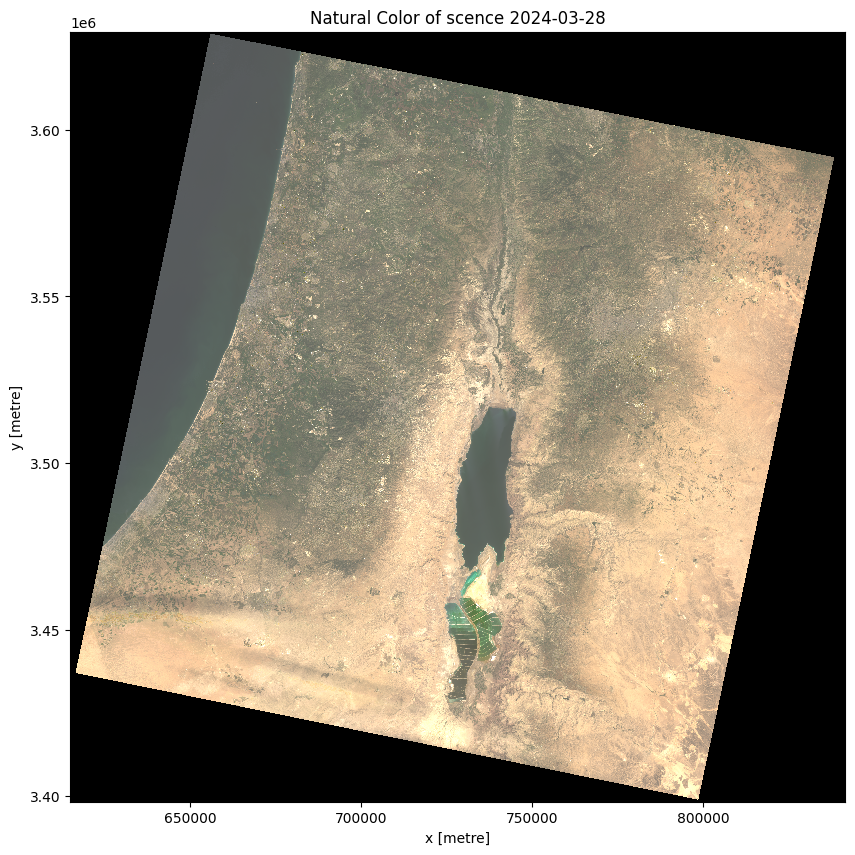

In [37]:
date = selected_item.datetime.date()
ddata = odc.stac.stac_load(
    [selected_item],
    bands=None,  # Load all available bands
    patch_url=planetary_computer.sign
).isel(time=0)

fig, ax = plt.subplots(figsize=(10, 10))

ddata[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)
ax.set_title(f"Natural Color of scence {date}");

# Save the plot as an image
output_path = "natural_color_selected_file.png"
plt.savefig(output_path, dpi=600, bbox_inches='tight')
plt.show()


we git the scence obtained at  2024-03-28 08:10:41

lets plot plygon's rgb to see that we are looking on the right roi

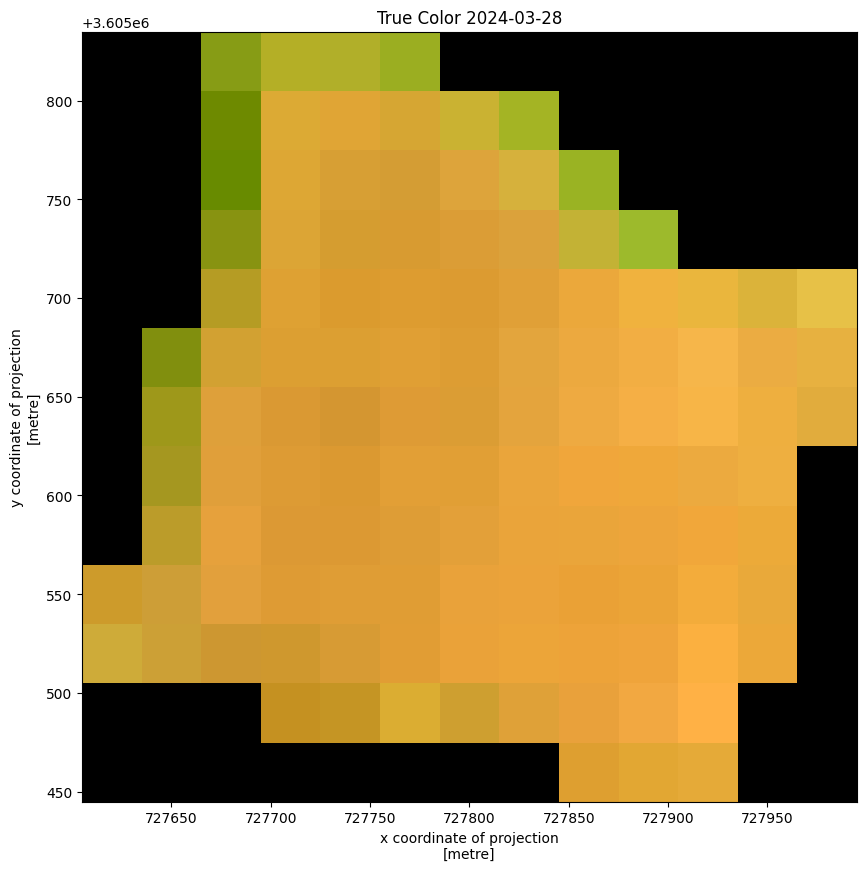

In [38]:
import matplotlib.pyplot as plt
from shapely.geometry import shape
import geopandas as gpd
import rioxarray
import planetary_computer

date = selected_item.datetime.date()
# Convert your polygon GeoJSON to a GeoDataFrame
polygon_gdf = gpd.GeoDataFrame(geometry=[shape(polygon_geojson)], crs="EPSG:4326")
bbox = polygon.bounds  # Get the bounding box coordinates (min_lon, min_lat, max_lon, max_lat)
bands_of_interest = ["red", "green", "blue"]


data = odc.stac.stac_load(
    [selected_item],
    bands=bands_of_interest,  # Load all available bands
    bbox=bbox,
    patch_url=planetary_computer.sign
).isel(time=0)

# Clip the data to the polygon
clipped_data = data.rio.clip([polygon_gdf.geometry[0]], polygon_gdf.crs, all_touched=True)

# For demonstration, let's plot the "Natural Color" (RGB) image
rgb_bands = ["red", "green", "blue"]

# Extract the RGB bands and plot
rgb_data = clipped_data[bands_of_interest].to_array()

# Define a threshold to exclude black pixels (if not we get faded image)
threshold = 0.05  # Values below this are considered black pixels

# Create a mask to exclude dark pixels (values below the threshold)
mask = (rgb_data > threshold)

# Apply the mask and calculate min/max on the non-masked (non-black) pixels
masked_data = rgb_data.where(mask)

# Calculate the min and max values from the masked data
vmin = masked_data.min(skipna=True)
vmax = masked_data.max(skipna=True)

# Plot the image using the new vmin and vmax values
fig, ax = plt.subplots(figsize=(10, 10))
rgb_data.plot.imshow(vmin=vmin, vmax=vmax, ax=ax)
ax.set_title(f'True Color {date}')
plt.show()

I wanted to make sure im on the right place so rescale the polygon and plot its rgb image

Bounding Box: (35.41157842700001, 32.55171358349999, 35.44136207499999, 32.5779859915)


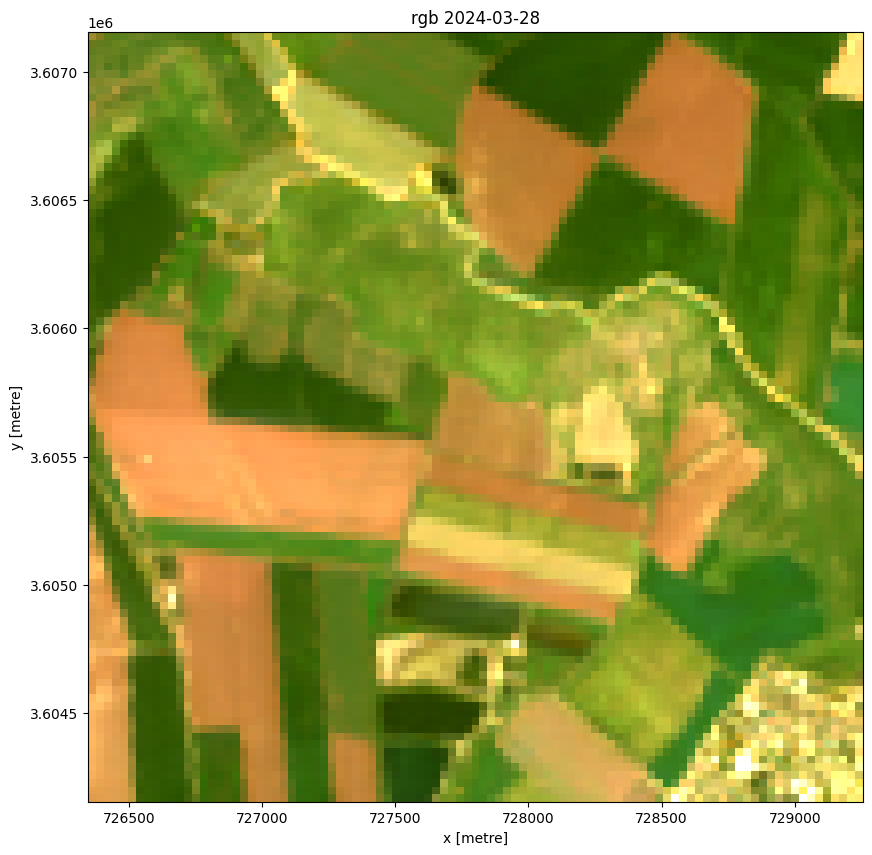

In [39]:
from shapely.geometry import Polygon, box, shape
import matplotlib.pyplot as plt
import odc


def create_enlarged_bbox(polygon_geojson, enlargement_factor=8):
    """
    Creates a bounding box that is 'enlargement_factor' times larger than the given polygon.

    """
    # Extract coordinates from GeoJSON
    coordinates = polygon_geojson['coordinates'][0]

    # Create a Shapely Polygon object
    polygon = Polygon(coordinates)

    # Calculate original bounding box
    minx, miny, maxx, maxy = polygon.bounds

    # Calculate width and height of the polygon
    width = maxx - minx
    height = maxy - miny

    # Calculate the center of the polygon
    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2

    # Calculate the enlarged width and height
    enlarged_width = width * enlargement_factor
    enlarged_height = height * enlargement_factor

    # Calculate the coordinates of the enlarged bounding box
    minx_enlarged = center_x - enlarged_width / 2
    miny_enlarged = center_y - enlarged_height / 2
    maxx_enlarged = center_x + enlarged_width / 2
    maxy_enlarged = center_y + enlarged_height / 2

    # Create the enlarged bounding box
    enlarged_bbox = box(minx_enlarged, miny_enlarged, maxx_enlarged, maxy_enlarged)

    # Convert Shapely bounding box to GeoJSON
    enlarged_bbox_geojson = {
        "type": "Polygon",
        "coordinates": [[
            [enlarged_bbox.exterior.coords[0][0], enlarged_bbox.exterior.coords[0][1]],
            [enlarged_bbox.exterior.coords[1][0], enlarged_bbox.exterior.coords[1][1]],
            [enlarged_bbox.exterior.coords[2][0], enlarged_bbox.exterior.coords[2][1]],
            [enlarged_bbox.exterior.coords[3][0], enlarged_bbox.exterior.coords[3][1]],
            [enlarged_bbox.exterior.coords[0][0], enlarged_bbox.exterior.coords[0][1]]
        ]]
    }

    return enlarged_bbox_geojson



# Create the enlarged bounding box
enlarged_bbox_geojson = create_enlarged_bbox(polygon_geojson)

# Convert enlarged bounding box GeoJSON to Shapely object
enlarged_polygon = shape(enlarged_bbox_geojson)

# Get the bounding box
bbox = enlarged_polygon.bounds  # Returns (min_lon, min_lat, max_lon, max_lat)
print("Bounding Box:", bbox)

# Prepare for loading data
bands_of_interest = ["red", "green","blue" ]

# Load the data with the bounding box of interest, including all bands
data = odc.stac.stac_load(
    [selected_item],
    bands=bands_of_interest,
    bbox=bbox,
    patch_url=planetary_computer.sign
).isel(time=0)

# Adjust the bands used based on the available bands in your data

# Extract the RGB bands and plot
rgb_data = data[bands_of_interest].to_array()
fig, ax = plt.subplots(figsize=(10, 10))
rgb_data.plot.imshow(robust=True, ax=ax)
ax.set_title(f'rgb {date}')
plt.show()


# extracting the wanted data- relevant band of the polygon:

we want to extracrt only the data we need

based that :
 "coastal", "blue", "green", "red", "nir08", "swir16", "swir22", "lwir11"
is "B1", "B2" ...B7", "B10"  respectively

In [40]:
import xarray as xr
import geopandas as gpd
from shapely.geometry import shape
import planetary_computer
import odc.stac

# Define bands of interest
bands_of_interest = ["coastal", "blue", "green", "red", "nir08", "swir16", "swir22", "lwir11"]

# Convert your polygon GeoJSON to a GeoDataFrame
polygon_gdf = gpd.GeoDataFrame(geometry=[shape(polygon_geojson)], crs="EPSG:4326")

# Extract the bounding box of the polygon
bbox = polygon_gdf.total_bounds  # [min_lon, min_lat, max_lon, max_lat]

# Load the data with the bounding box of interest, including all bands
data = odc.stac.stac_load(
    [selected_item],
    bands=bands_of_interest,  # Load all relevant bands
    bbox=bbox,
    patch_url=planetary_computer.sign,
).isel(time=0)

# Clip the data to the polygon - remove pixels outside of the polygon
data.rio.set_crs("EPSG:4326", inplace=True)  # Set CRS if not already defined
clipped_data = data.rio.clip([polygon_gdf.geometry[0]], polygon_gdf.crs, all_touched=True) # include also pixels not fully in the polygon

# Save the clipped data as a NetCDF file
#clipped_data.to_netcdf('clipped_data.nc', format='NETCDF4')


<ipython-input-40-13f30cf42ea8>:25: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  data.rio.set_crs("EPSG:4326", inplace=True)  # Set CRS if not already defined


In [41]:

# Optionally save as a CSV (flattening multi-dimensional data)
df = clipped_data.to_dataframe().reset_index()


# Save the cleaned DataFrame to a CSV file
df.to_csv('clipped_data.csv', index=False)

#save the data as csv file:

In [42]:
import pandas as pd
non_zero_indices = []
# Get all band names from the data
all_bands = list(clipped_data.data_vars) # Use data.data_vars instead of data.columns

# Iterate over all bands and flatten each one into a 1D array
band_arrays = []
for band in all_bands:
    band_data = clipped_data[band].values.flatten()  # Flatten each band into a 1D array
    band_arrays.append(band_data)

# Track the indices of non-zero pixels -we need that for later to reproduce the map
non_zero_indices.append(np.where(band_data != 0)[0])


# Create a DataFrame with each band as a column
df = pd.DataFrame({band: band_arrays[i] for i, band in enumerate(all_bands)})
# Convert DataFrame to numeric to handle mixed types, if any
df = df.apply(pd.to_numeric, errors='coerce')

# Remove rows where all values are 0
df = df.loc[(df!=0).any(axis=1)]

# Save the DataFrame as a CSV file
df.to_csv('bands.csv', index=False)

# **stage 2 - ML prediction**


#  scale the relevant bands:
lets preprocces the data and save it as csv file for the modeling,

also fit the names to the dataset names


In [43]:
import pandas as pd
import numpy as np

# Band mapping
band_mapping = {
    'coastal': 'B1',
    'blue': 'B2',
    'green': 'B3',
    'red': 'B4',
    'nir08': 'B5',
    'swir16': 'B6',
    'swir22': 'B7',
    'lwir11': 'B10'
}

def scale_reflectance(value):
    """Scale surface reflectance bands."""
    scaled = (value * 0.0000275) - 0.2
    return scaled

def scale_temperature(value):
    """Scale surface temperature band."""
    scaled = (value * 0.00341802) + 149
    return scaled

# Read the CSV file
df = pd.read_csv('bands.csv')

# Scale and rename columns for surface reflectance bands
scaled_columns = {}
reflectance_bands = ['coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22']
for band in reflectance_bands:
    if band in df.columns:
        scaled_col = f'{band}_scaled'
        df[scaled_col] = scale_reflectance(df[band])
        scaled_columns[scaled_col] = band_mapping[band]  # Map to B1, B2, etc.

# Scale and rename the surface temperature band
if 'lwir11' in df.columns:
    scaled_col = 'lwir11_scaled'
    df[scaled_col] = scale_temperature(df['lwir11'])
    scaled_columns[scaled_col] = band_mapping['lwir11']

# Create a new dataframe with scaled values and updated column names
scaled_df = df[list(scaled_columns.keys())]
scaled_df.columns = [scaled_columns[col] for col in scaled_df.columns]  # Rename to B1, B2, etc.

# Save the scaled data
scaled_df.to_csv('scaled_bands.csv', index=False)


# Machine Learning Models
I evaluated several algorithms:

Linear Regression
Random Forest
Gradient Boosting
Simple Fully Connected Neural Network (FC-NN)

I fine-tuned the hyperparameters of each model to optimize performance. After achieving the best results with the Random Forest model, I further experimented with improved Gradient Boosting and Neural Network models to enhance performance even more.



In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Read data without assuming header names
df = pd.read_csv('dataset.csv')
test_df = pd.read_csv('scaled_bands.csv')

# Use column positions directly
X = df.iloc[:, :7]  # First 7 columns as features
y = df.iloc[:, 8]   # 8th column as target
X_test_new = test_df.iloc[:, :7]  # First 7 columns for prediction



# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_new_scaled = scaler.transform(X_test_new)

# Initialize models
models = {
    'Linear_Regression': LinearRegression(),
    'Random_Forest': RandomForestRegressor(n_estimators=150, random_state=42),
    'Gradient_Boosting': GradientBoostingRegressor(n_estimators=150, random_state=42),
    'Neural_Network': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

models['Deep_Neural_Network'] = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32, 16, 8),  # Added more layers
    max_iter=2000,
    random_state=42,
    learning_rate_init=0.001,
    alpha=0.0001  # L2 regularization
)

models['improved_Gradient_Boosting'] = GradientBoostingRegressor(
    n_estimators=100,       # Increase the number of trees
    learning_rate=0.05,     # Lower learning rate for better generalization
    max_depth=4,            # Deeper trees may improve performance
    min_samples_leaf=10,    # Prevent overfitting by ensuring sufficient data in each leaf
    subsample=0.8,          # Use only 80% of the data for each tree
    validation_fraction=0.1,  # Use part of training data for early stopping
    n_iter_no_change=10,    # Early stopping if the model doesn't improve
    random_state=42
)


# Train models and make predictions
predictions = {}
predictions_train={}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train on full dataset
    model.fit(X, y)

    # Make predictions on test set
    pred = model.predict(X_test_new)
    predictions[f'{name}_prediction'] = pred

    pred2 = model.predict(X)
    predictions_train [f'{name}_prediction'] = pred2

# Create results DataFrame with train data and predictions

results_train =df.copy()
for name, pred in predictions_train.items():
    results_train[name] = pred

# Create results DataFrame with original data and predictions
results_df = test_df.copy()
for name, pred in predictions.items():
    results_df[name] = pred  # Add predictions as new columns

results_df.to_csv('results.csv', index=False)  # Save with original column names

# For training results, keep the original column names
for name, pred in predictions_train.items():
    results_train[name] = pred  # Add predictions as new columns

results_train.to_csv('results_train.csv', index=False)





Training Linear_Regression...

Training Random_Forest...

Training Gradient_Boosting...

Training Neural_Network...

Training Deep_Neural_Network...

Training improved_Gradient_Boosting...


In [45]:

# Band importance for  models
def get_feature_importance(model, model_name):
    column_names = X.columns
    if hasattr(model, 'feature_importances_'):
        importance = pd.DataFrame({
            'Band': column_names,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        print(f"\n{model_name} Feature Importance:")
        print(importance)
        return importance

print("\nFeature Importance Analysis:")
get_feature_importance(models['Random_Forest'], 'Random Forest')
get_feature_importance(models['Gradient_Boosting'], 'Gradient Boosting')


Feature Importance Analysis:

Random Forest Feature Importance:
  Band  Importance
4   B5    0.559465
0   B1    0.133885
6   B7    0.081347
3   B4    0.060167
5   B6    0.058802
1   B2    0.056807
2   B3    0.049527

Gradient Boosting Feature Importance:
  Band  Importance
4   B5    0.738402
0   B1    0.133427
6   B7    0.053964
3   B4    0.021932
5   B6    0.019809
1   B2    0.019073
2   B3    0.013393


,Band,Importance
4,B5,0.738402
0,B1,0.133427
6,B7,0.053964
3,B4,0.021932
5,B6,0.019809
1,B2,0.019073
2,B3,0.013393



Calculating accuracy metrics for Linear_Regression on training data...
R²: 0.6552
RMSE: 0.1016

Calculating accuracy metrics for Random_Forest on training data...
R²: 0.9463
RMSE: 0.0401

Calculating accuracy metrics for Gradient_Boosting on training data...
R²: 0.6876
RMSE: 0.0968

Calculating accuracy metrics for Neural_Network on training data...
R²: 0.6507
RMSE: 0.1023

Calculating accuracy metrics for Deep_Neural_Network on training data...
R²: 0.6342
RMSE: 0.1047

Calculating accuracy metrics for improved_Gradient_Boosting on training data...
R²: 0.6515
RMSE: 0.1022

Training Metrics Summary:
                                  R2      RMSE
Linear_Regression           0.655210  0.101634
Random_Forest               0.946262  0.040124
Gradient_Boosting           0.687552  0.096750
Neural_Network              0.650680  0.102300
Deep_Neural_Network         0.634245  0.104679
improved_Gradient_Boosting  0.651526  0.102176


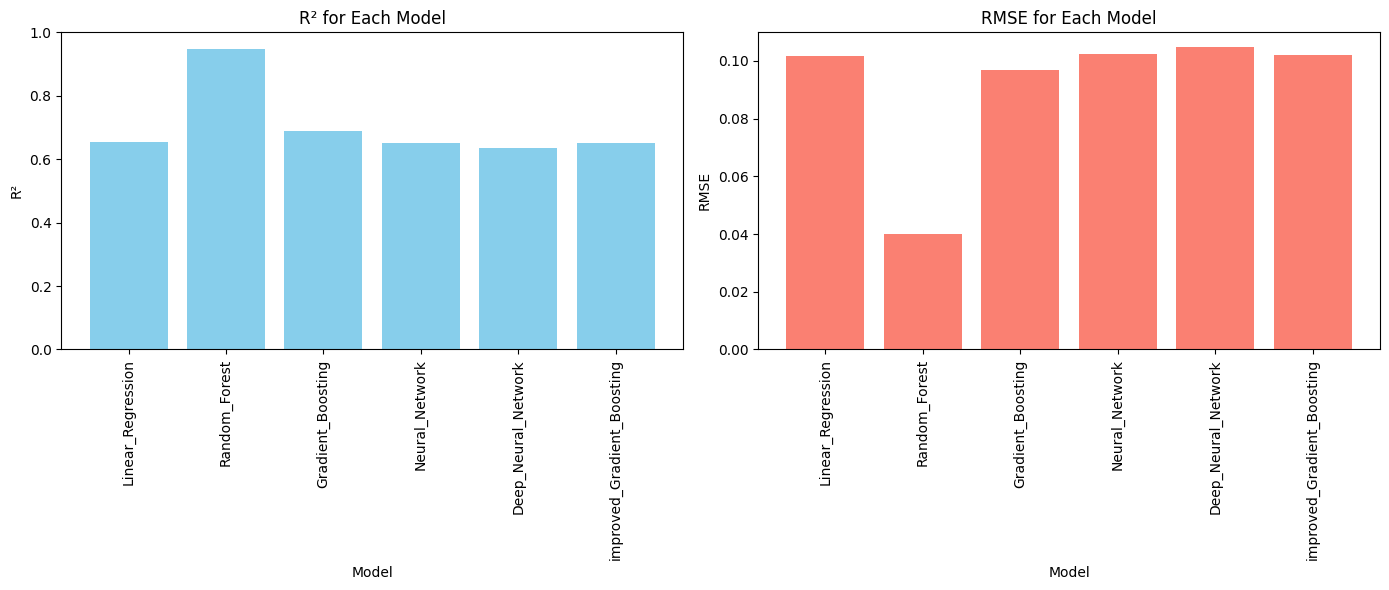

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Initialize a dictionary to store metrics
training_metrics = {}

# Calculate accuracy for each model on training data
for name, model in models.items():
    print(f"\nCalculating accuracy metrics for {name} on training data...")

    # Make predictions on training data
    train_pred = model.predict(X)

    # Compute R² and RMSE
    r2 = r2_score(y, train_pred)
    rmse = np.sqrt(mean_squared_error(y, train_pred))

    # Store metrics
    training_metrics[name] = {'R2': r2, 'RMSE': rmse}

    # Print metrics
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

# Convert metrics to a DataFrame for better visualization
metrics_df = pd.DataFrame(training_metrics).T
print("\nTraining Metrics Summary:")
print(metrics_df)

# save the metrics to a CSV
#metrics_df.to_csv('training_metrics.csv', index=True)

# Plot the R² and RMSE for each model
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot R²
ax[0].bar(metrics_df.index, metrics_df['R2'], color='skyblue')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title('R² for Each Model')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('R²')
ax[0].set_ylim([0, 1])

# Plot RMSE
ax[1].bar(metrics_df.index, metrics_df['RMSE'], color='salmon')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title('RMSE for Each Model')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('RMSE')

plt.tight_layout()
plt.show()


# create yield map

the best model - random forest

now the only thing we have got to do is to create map of its

yield results

In [47]:

# Load the predictions from the CSV file
results_df = pd.read_csv('results.csv')

# Extract the predicted values (Random_Forest_prediction column)
predictions = results_df['Random_Forest_prediction'].values


# Get the shape of your original raster
raster_shape = clipped_data['red'].shape  #  'red' is a representative band

# Initialize an array of NaNs (or zeros) to hold the yield map
yield_map = np.full(raster_shape, np.nan)

# Get the indices of the non-zero pixels (you can reuse your previous method)
non_zero_indices = np.where(clipped_data['red'].values.flatten() != 0)[0]

# Check if the number of non-zero pixels matches the number of predictions
if len(non_zero_indices) != len(predictions):
    raise ValueError("The number of predictions does not match the number of non-zero pixels.")

# Place the predictions back into the yield map at the non-zero locations
yield_map.ravel()[non_zero_indices] = predictions


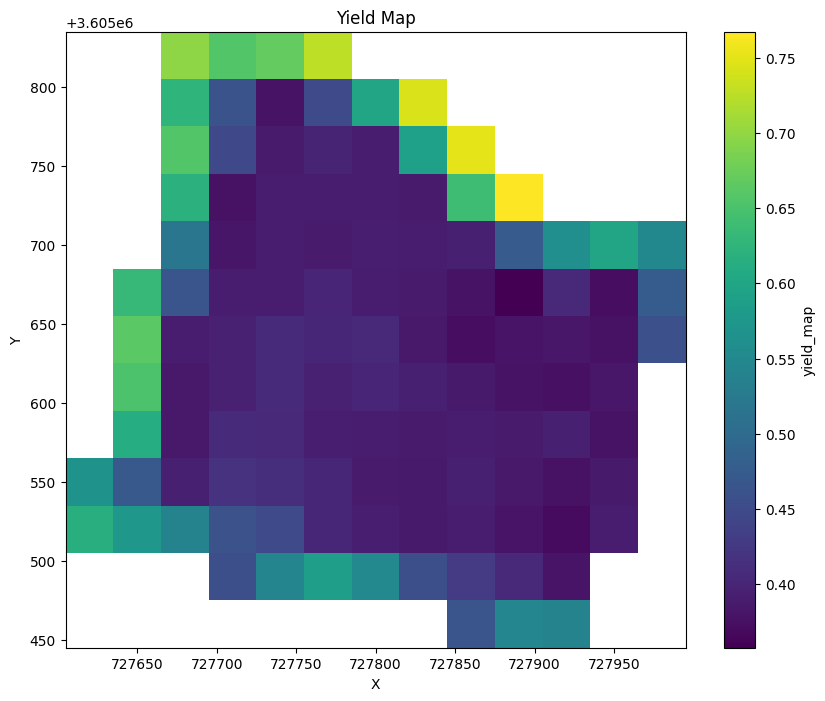

In [48]:
import matplotlib.pyplot as plt

# Add the yield_map to the clipped_data as a new variable
clipped_data['yield_map'] = (('y', 'x'), yield_map)  # Assuming 'y' and 'x' are the spatial dimensions

# Plot the yield_map using xarray's plot method
plt.figure(figsize=(10, 8))
clipped_data['yield_map'].plot(cmap='viridis')  # Adjust the colormap as needed
plt.title("Yield Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
